In [ ]:
# استيراد المكتبات
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
# Import ConfusionMatrixDisplay instead of plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings

# تحميل بيانات تويتر
df = pd.read_csv('/content/Tweets.csv')

# استكشاف البيانات
df.info()
df.describe().T
df['airline_sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


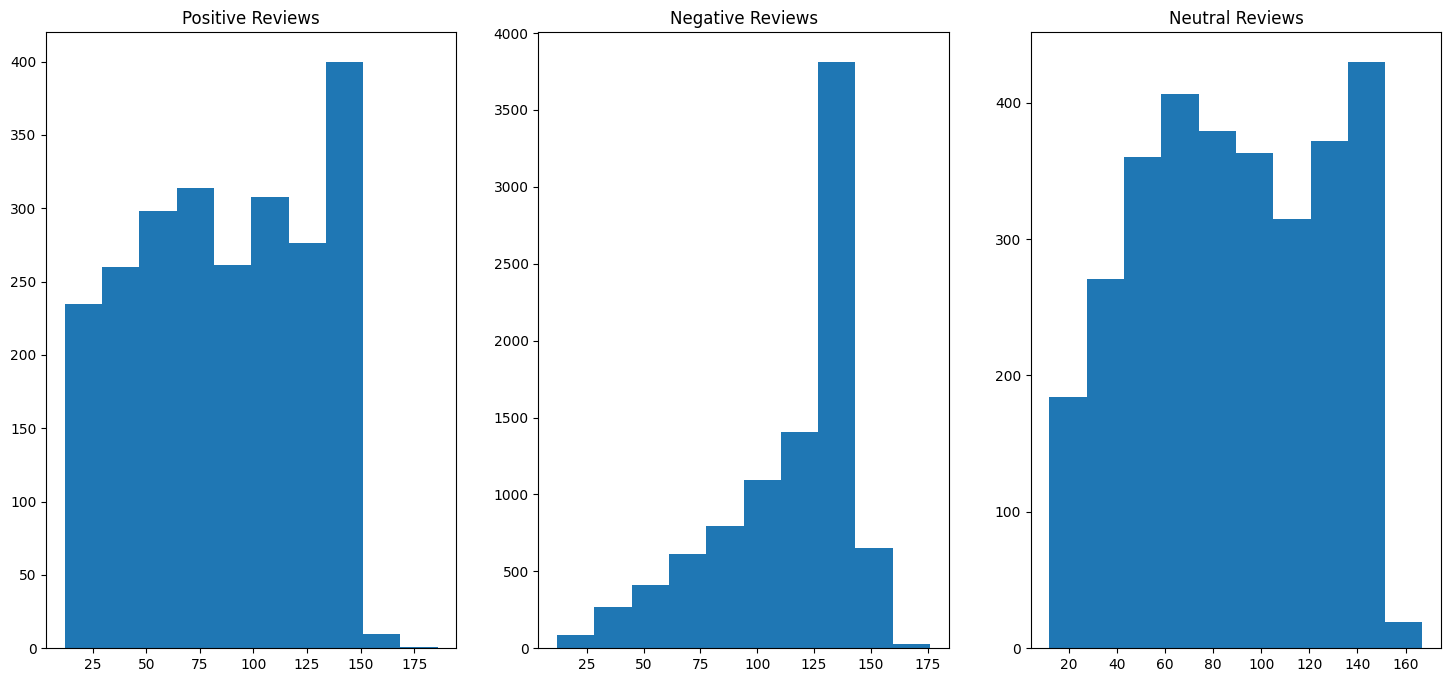

In [ ]:
# توزيع طول النصوص بناءً على المشاعر
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,8))
ax1.hist(df[df['airline_sentiment']=='positive']['text'].str.len())
ax1.set_title('Positive Reviews')
ax2.hist(df[df['airline_sentiment']=='negative']['text'].str.len())
ax2.set_title('Negative Reviews')
ax3.hist(df[df['airline_sentiment']=='neutral']['text'].str.len())
ax3.set_title('Neutral Reviews')
plt.show()





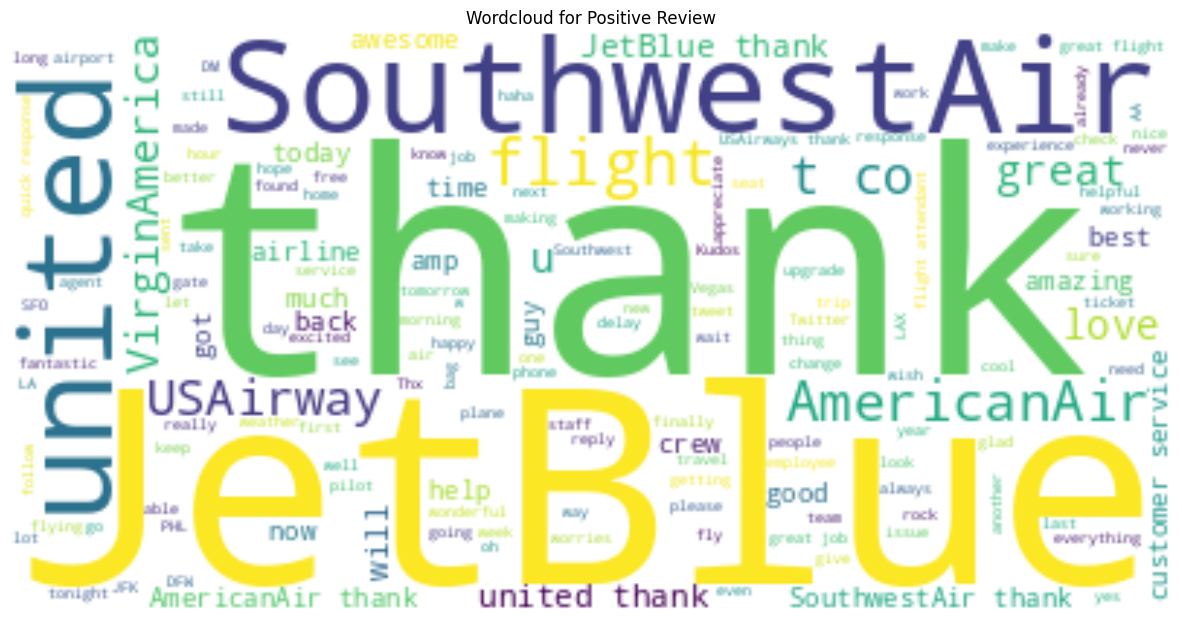

In [ ]:
# توليد سحابة كلمات للتعليقات الإيجابية
text = " ".join(i for i in df[df['airline_sentiment']=='positive']['text'])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for Positive Review')
plt.show()

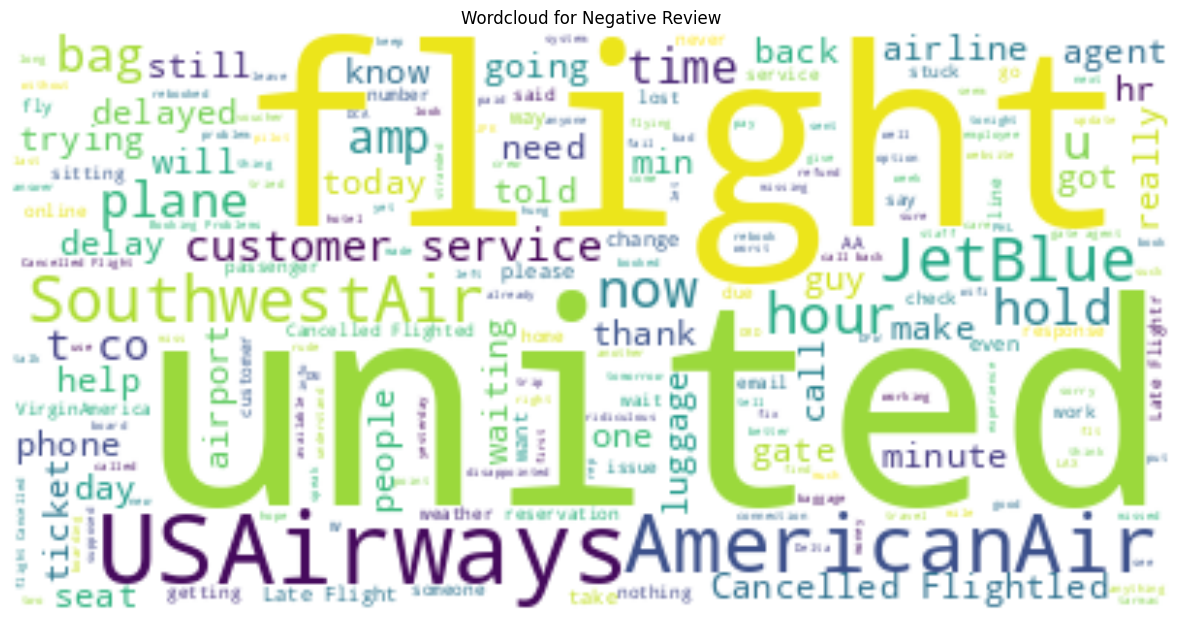

In [ ]:
# توليد سحابة كلمات للتعليقات السلبية
text = " ".join(i for i in df[df['airline_sentiment']=='negative']['text'])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for Negative Review')
plt.show()

In [ ]:
import nltk
# Download the stopwords resource
nltk.download('stopwords')
# Download the wordnet resource
nltk.download('wordnet') # Download wordnet

# ... (rest of your code) ...


# إزالة الكلمات التوقفية
stop_words = stopwords.words('english')
df['no_sw'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# إعادة تسمية العمود النصي
df.rename(columns={'text':'text', 'airline_sentiment':'sentiment'}, inplace=True)

# تنظيف النصوص
def cleaning(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r"\b\d+\b", "", text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    return text

df['text'] = df['text'].apply(cleaning)

# إزالة الكلمات التوقفية
stop_words = stopwords.words('english')
df['no_sw'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# تحليل الكلمات الأكثر شيوعًا
cnt = Counter()
for text in df["no_sw"].values:
    for word in text.split():
        cnt[word] += 1
temp = pd.DataFrame(cnt.most_common(10))
temp.columns = ['word', 'count']
px.bar(temp, x="count", y="word", title='Common Words in Text', orientation='h', width=700, height=700)

# إزالة الكلمات الشائعة
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
df["wo_stopfreq"] = df["no_sw"].apply(lambda text: " ".join([word for word in str(text).split() if word not in FREQWORDS]))

# تليمايز النصوص
wordnet_lem = WordNetLemmatizer()
df['wo_stopfreq_lem'] = df['wo_stopfreq'].apply(wordnet_lem.lemmatize)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


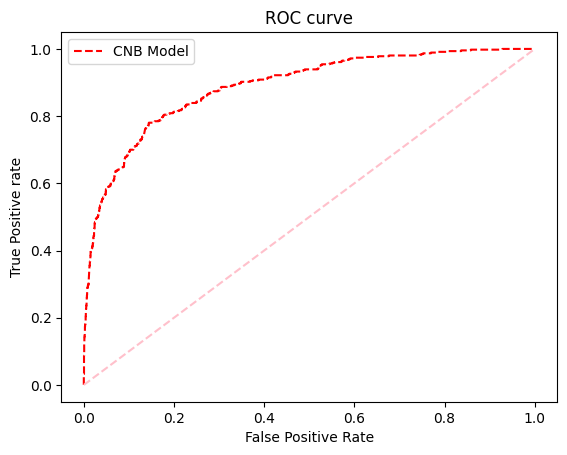

In [ ]:
# ROC Curve
CNB_prob = CNB.predict_proba(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test, CNB_prob[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='CNB Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='pink')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC', dpi=300)
plt.show()


In [ ]:
# تحليل الكلمات الأكثر شيوعًا باستخدام الرسوم البيانية
temp = pd.DataFrame(cnt.most_common(10))
temp.columns = ['word', 'count']
px.bar(temp, x="count", y="word", title='Common Words in Text', orientation='h', width=700, height=700)


In [ ]:
# تحويل المشاعر إلى قيم رقمية
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == "positive" else (0 if x == "negative" else 2))

# تقسيم البيانات إلى تدريب واختبار
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english', tokenizer=token.tokenize)
text_counts = cv.fit_transform(df['wo_stopfreq_lem'])

X = text_counts
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)

# نموذج Naive Bayes
CNB = ComplementNB()
CNB.fit(X_train, y_train)
predicted = CNB.predict(X_test)
accuracy_score_cnb = metrics.accuracy_score(predicted, y_test)
print('ComplementNB model accuracy is', str('{:04.2f}'.format(accuracy_score_cnb*100))+'%')

# Confusion Matrix and Classification Report
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('Classification Report:')
print(classification_report(y_test, predicted))


ComplementNB model accuracy is 100.00%
Confusion Matrix:
      0
0  2928
Classification Report:
              precision    recall  f1-score   support

           2       1.00      1.00      1.00      2928

    accuracy                           1.00      2928
   macro avg       1.00      1.00      1.00      2928
weighted avg       1.00      1.00      1.00      2928



In [ ]:
# تدريب نموذج MultinomialNB
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train, y_train)

# التنبؤ والتحقق من الدقة
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinominalNB model accuracy is', str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))


MultinominalNB model accuracy is 74.56%
------------------------------------------------
Confusion Matrix:
      0    1    2
0  1700   48   87
1   181  231   48
2   340   41  252
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1835
           1       0.72      0.50      0.59       460
           2       0.65      0.40      0.49       633

    accuracy                           0.75      2928
   macro avg       0.71      0.61      0.64      2928
weighted avg       0.73      0.75      0.73      2928



In [ ]:
# تدريب نموذج BernoulliNB
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X_train, y_train)

# التنبؤ والتحقق من الدقة
predicted = BNB.predict(X_test)
accuracy_score_bnb = metrics.accuracy_score(predicted, y_test)

print('BernoulliNB model accuracy = ' + str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))


BernoulliNB model accuracy = 70.36%
------------------------------------------------
Confusion Matrix:
      0    1    2
0  1740   26   69
1   286  126   48
2   421   18  194
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.95      0.81      1835
           1       0.74      0.27      0.40       460
           2       0.62      0.31      0.41       633

    accuracy                           0.70      2928
   macro avg       0.69      0.51      0.54      2928
weighted avg       0.70      0.70      0.66      2928



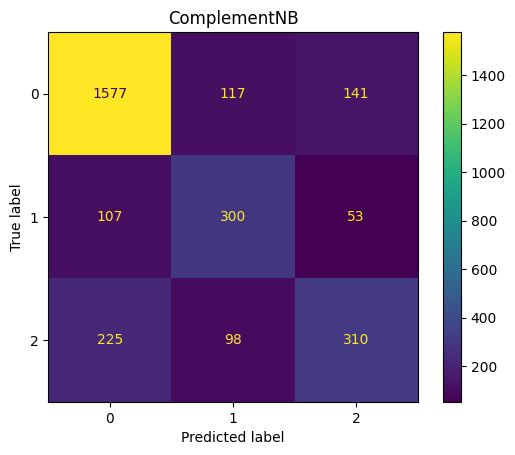

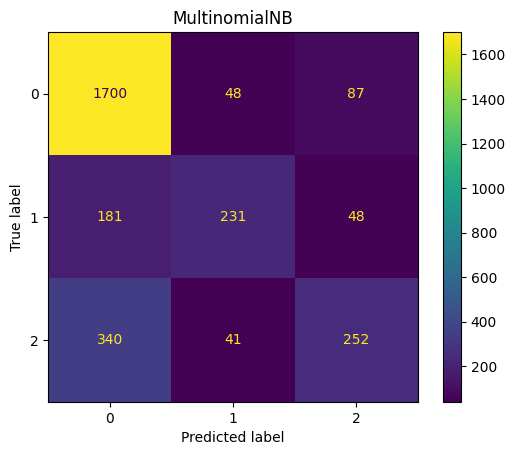

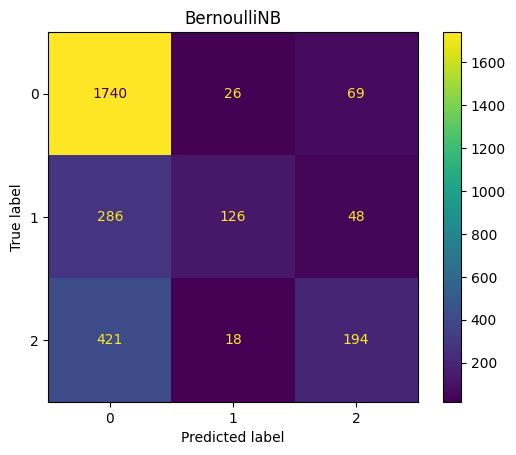

In [ ]:
# عرض Confusion Matrix لكل نموذج
from sklearn.metrics import ConfusionMatrixDisplay # Import ConfusionMatrixDisplay instead
import warnings
warnings.filterwarnings("ignore")

# النماذج المستخدمة
models = [CNB, MNB, BNB]

# رسم Confusion Matrix لكل نموذج
for model in models:
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test) # Use from_estimator
    disp.ax_.set_title(type(model).__name__) # Set title using disp.ax_
    plt.show()

In [ ]:
# إنشاء المصفوفة باستخدام 2-grams
cv_twograms = CountVectorizer(stop_words='english', ngram_range=(2, 2), tokenizer=token.tokenize)
text_counts_twograms = cv_twograms.fit_transform(df['wo_stopfreq_lem'])

# تقسيم البيانات وتدريب نموذج MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(text_counts_twograms, df['sentiment'], test_size=0.20, random_state=30)

MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)
print('2-grams model accuracy is', str('{:04.2f}'.format(accuracy_score*100))+'%')


2-grams model accuracy is 46.96%


In [ ]:
# إنشاء المصفوفة باستخدام 3-grams
cv_threegrams = CountVectorizer(stop_words='english', ngram_range=(3, 3), tokenizer=token.tokenize)
text_counts_threegrams = cv_threegrams.fit_transform(df['wo_stopfreq_lem'])

# تقسيم البيانات وتدريب نموذج MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(text_counts_threegrams, df['sentiment'], test_size=0.20, random_state=30)

MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)
print('3-grams model accuracy is', str('{:04.2f}'.format(accuracy_score*100))+'%')


3-grams model accuracy is 27.66%


In [ ]:
# استخدام TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
text_count_2 = tfidf.fit_transform(df['wo_stopfreq_lem'])

# تقسيم البيانات وتدريب النماذج
x_train, x_test, y_train, y_test = train_test_split(text_count_2, df['sentiment'], test_size=0.20, random_state=30)

# نموذج MultinomialNB
MNB.fit(x_train, y_train)
accuracy_score_mnb = metrics.accuracy_score(MNB.predict(x_test), y_test)
print('MultinomialNB accuracy = '+str('{:4.2f}'.format(accuracy_score_mnb*100))+'%')

# نموذج BernoulliNB
BNB.fit(x_train, y_train)
accuracy_score_bnb = metrics.accuracy_score(BNB.predict(x_test), y_test)
print('BernoulliNB accuracy = '+str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')

# نموذج ComplementNB
CNB.fit(x_train, y_train)
accuracy_score_cnb = metrics.accuracy_score(CNB.predict(x_test), y_test)
print('ComplementNB accuracy = '+str('{:4.2f}'.format(accuracy_score_cnb*100))+'%')


MultinomialNB accuracy = 68.31%
BernoulliNB accuracy = 71.52%
ComplementNB accuracy = 75.24%
